##Graph VAE

In [1]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
import os
import ast
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers, ops

# Install RDKit if it's not already installed
try:
    from rdkit import Chem, RDLogger
except ImportError:
    print("RDKit not found, installing...")
    !pip install rdkit
    from rdkit import Chem, RDLogger

from rdkit.Chem import BondType

# Disable RDKit warnings (logs) to keep the output clean during training
RDLogger.DisableLog("rdApp.*")

print("Libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

RDKit not found, installing...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 65.1 MB/s eta 0:00:00
Libraries imported successfully.
TensorFlow Version: 2.19.0
Keras Version: 3.10.0


In [3]:
# ==========================================
# 1. CONFIGURATION FOR QM9
# ==========================================
class Config:
    # QM9 specific constraints
    MAX_ATOMS = 9         # Molecules in QM9 have at most 9 heavy atoms (C, N, O, F)
    ATOM_TYPES = ["C", "N", "O", "F"] # We treat Hydrogen as implicit to simplify the graph

    # Bond types to learn (AROMATIC removed for better validity)
    BOND_MAPPING = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2}
    NUM_BONDS = len(BOND_MAPPING)

    # QM9 Property features for conditioning (HOMO, LUMO, gap, dipole)
    PROPERTY_DIM = 4

    # Training Hyperparameters
    LATENT_DIM = 128      # Increased for better expressiveness
    BATCH_SIZE = 32
    EPOCHS = 50           # Enough to converge on this small dataset
    LEARNING_RATE = 1e-3

CONFIG = Config()

# --- Mapping Utilities (Helpers) ---
# These convert between "Human Readable" (SMILES) and "Machine Readable" (Index)

# Map atom symbol to integer (e.g., "C" -> 0)
SMILE_TO_INDEX = {c: i for i, c in enumerate(CONFIG.ATOM_TYPES)}

# Map integer back to symbol (e.g., 0 -> "C")
INDEX_TO_SMILE = {i: c for i, c in enumerate(CONFIG.ATOM_TYPES)}

# Map bond string to integer (e.g., "DOUBLE" -> 1)
BOND_TO_INDEX = CONFIG.BOND_MAPPING

# Map RDKit Bond Objects to our integers (for preprocessing)
RDKIT_BOND_TYPES = {
    0: BondType.SINGLE,
    1: BondType.DOUBLE,
    2: BondType.TRIPLE
}

# Valence rules for chemical validity
VALENCE_RULES = {"C": 4, "N": 3, "O": 2, "F": 1}

print(f"Configuration Loaded.")
print(f"Max Atoms: {CONFIG.MAX_ATOMS}")
print(f"Atom Types: {CONFIG.ATOM_TYPES}")

Configuration Loaded.
Max Atoms: 9
Atom Types: ['C', 'N', 'O', 'F']


In [4]:
# ==========================================
# 2. DATA LOADING (QM9) WITH PROPERTIES
# ==========================================
from sklearn.preprocessing import MinMaxScaler

def load_qm9_dataset():
    print("Downloading QM9 dataset...")

    # We use Keras to cache the file so we don't download it twice
    csv_path = keras.utils.get_file(
        "qm9.csv",
        "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
    )

    # Read into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # The QM9 CSV from DeepChem usually has the SMILES in a column named 'smiles' or 'SMILES1'
    if 'smiles' in df.columns:
        smiles_data = df['smiles'].values
    elif 'SMILES1' in df.columns:
        smiles_data = df['SMILES1'].values
    else:
        raise ValueError("Could not find SMILES column in the downloaded QM9 CSV.")

    # Extract molecular properties for conditioning
    # Using: HOMO, LUMO, gap, dipole moment (mu)
    properties = df[['homo', 'lumo', 'gap', 'mu']].values

    return smiles_data, properties

# --- Execute Loading ---
qm9_smiles, qm9_properties = load_qm9_dataset()

# Shuffle both arrays together to maintain correspondence
indices = np.arange(len(qm9_smiles))
np.random.shuffle(indices)
qm9_smiles = qm9_smiles[indices]
qm9_properties = qm9_properties[indices]

# Normalize properties to [0, 1] range for better training
scaler = MinMaxScaler()
qm9_properties = scaler.fit_transform(qm9_properties)

# Let's verify what we loaded
print(f"Successfully loaded {len(qm9_smiles)} molecules.")
print(f"Properties shape: {qm9_properties.shape}")
print(f"Example SMILES: {qm9_smiles[:5]}")

29856825/29856825 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Successfully loaded 133885 molecules.
Properties shape: (133885, 4)
Example SMILES: ['CCN1CC=C(C1=O)C' 'NC(=O)C(=O)C1CC1O' 'CC12CC1(C)N(C2)C=O'
 'C1C2N1C1(CC1)C21CO1' 'OC1C2OC3CC3C12']


In [5]:
import pandas as pd
from tensorflow import keras

def visualize_qm9_head():
    print("Loading QM9 Dataset for inspection...")

    # 1. Download/Locate the file
    csv_path = keras.utils.get_file(
        "qm9.csv",
        "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
    )

    # 2. Read into DataFrame
    df = pd.read_csv(csv_path)

    # 3. Display the first 5 rows
    print(f"Dataset Shape: {df.shape}")
    print("-" * 60)
    print(df.head())
    print("-" * 60)

    # Check for the correct SMILES column
    if 'smiles' in df.columns:
        print(f"SMILES column found: 'smiles'")
        print(f"Sample: {df['smiles'].iloc[0]}")
    elif 'SMILES1' in df.columns:
        print(f"SMILES column found: 'SMILES1'")
        print(f"Sample: {df['SMILES1'].iloc[0]}")

    return df

# Execute
df = visualize_qm9_head()
df.head()

Loading QM9 Dataset for inspection...
Dataset Shape: (133885, 21)
------------------------------------------------------------
  mol_id smiles          A           B           C      mu  alpha    homo  \
0  gdb_1      C  157.71180  157.709970  157.706990  0.0000  13.21 -0.3877   
1  gdb_2      N  293.60975  293.541110  191.393970  1.6256   9.46 -0.2570   
2  gdb_3      O  799.58812  437.903860  282.945450  1.8511   6.31 -0.2928   
3  gdb_4    C#C    0.00000   35.610036   35.610036  0.0000  16.28 -0.2845   
4  gdb_5    C#N    0.00000   44.593883   44.593883  2.8937  12.99 -0.3604   

     lumo     gap  ...      zpve         u0       u298       h298       g298  \
0  0.1171  0.5048  ...  0.044749 -40.478930 -40.476062 -40.475117 -40.498597   
1  0.0829  0.3399  ...  0.034358 -56.525887 -56.523026 -56.522082 -56.544961   
2  0.0687  0.3615  ...  0.021375 -76.404702 -76.401867 -76.400922 -76.422349   
3  0.0506  0.3351  ...  0.026841 -77.308427 -77.305527 -77.304583 -77.327429   
4  0.0191 

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


In [6]:
from rdkit import Chem
import numpy as np

# ==========================================
# 1. MAPPINGS
# ==========================================
SMILE_TO_INDEX = {s: i for i, s in enumerate(CONFIG.ATOM_TYPES)}
INDEX_TO_SMILE = {i: s for i, s in enumerate(CONFIG.ATOM_TYPES)}
BOND_TO_INDEX = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2}
VALENCE_RULES = {"C": 4, "N": 3, "O": 2, "F": 1}
RDKIT_BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE
]

# ==========================================
# 2. SMILES TO GRAPH (Updated for 3 bond types)
# ==========================================
def smiles_to_graph(smiles, config):
    """
    Parses a SMILES string into Adjacency and Feature tensors.
    Arguments:
        smiles: The molecule string (e.g., "C=C")
        config: The configuration object containing MAX_ATOMS, ATOM_TYPES, etc.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None

    # R-GCN: Channels = [Single, Double, Triple, No-Bond]
    adj = np.zeros((config.NUM_BONDS + 1, config.MAX_ATOMS, config.MAX_ATOMS), dtype="float32")
    feat = np.zeros((config.MAX_ATOMS, len(config.ATOM_TYPES) + 1), dtype="float32")

    # 1. ATOMS
    for atom in mol.GetAtoms():
        i = atom.GetIdx()
        if i < config.MAX_ATOMS:
            sym = atom.GetSymbol()
            if sym in SMILE_TO_INDEX:
                feat[i, SMILE_TO_INDEX[sym]] = 1.0
            else:
                feat[i, -1] = 1.0 # Unknown

    # 2. BONDS
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        if i < config.MAX_ATOMS and j < config.MAX_ATOMS:
            b_type = str(bond.GetBondType())
            # Only process non-aromatic bonds
            if b_type in BOND_TO_INDEX:
                b_idx = BOND_TO_INDEX[b_type]
                adj[b_idx, i, j] = 1.0
                adj[b_idx, j, i] = 1.0
            # Treat aromatic as single bond (simplification)
            elif b_type == "AROMATIC":
                adj[0, i, j] = 1.0
                adj[0, j, i] = 1.0

    # 3. NO-BOND MASK (Last Channel)
    mask = np.sum(adj[:-1], axis=0) == 0
    adj[-1, mask] = 1.0

    # Feature Padding
    feat_mask = np.sum(feat[:, :-1], axis=1) == 0
    feat[feat_mask, -1] = 1.0

    return adj, feat

# ==========================================
# 3. IMPROVED GRAPH TO MOLECULE (With valence checking)
# ==========================================
def graph_to_molecule(adjacency, features, check_valence=True):
    """
    Converts predicted adjacency and features back to RDKit molecule.
    Now with padding filtering and optional valence checking.
    """
    mol = Chem.RWMol()
    atom_indices = np.argmax(features, axis=1)
    idx_map = {}
    valence_count = {}

    # Add Atoms (FILTER OUT PADDING)
    for i, idx in enumerate(atom_indices):
        # CRITICAL: Skip padding tokens (last index)
        if idx < len(CONFIG.ATOM_TYPES):
            symbol = INDEX_TO_SMILE[idx]
            new_idx = mol.AddAtom(Chem.Atom(symbol))
            idx_map[i] = new_idx
            valence_count[i] = 0

    # Add Bonds with Valence Checking
    for i in range(CONFIG.MAX_ATOMS):
        for j in range(i + 1, CONFIG.MAX_ATOMS):
            if i in idx_map and j in idx_map:
                b_idx = np.argmax(adjacency[:, i, j])
                if b_idx < CONFIG.NUM_BONDS:
                    # Determine bond order (1, 2, or 3)
                    bond_order = b_idx + 1

                    if check_valence:
                        # Get atom symbols
                        atom_i_symbol = INDEX_TO_SMILE[atom_indices[i]]
                        atom_j_symbol = INDEX_TO_SMILE[atom_indices[j]]

                        # Check if adding this bond would exceed valence
                        max_valence_i = VALENCE_RULES.get(atom_i_symbol, 4)
                        max_valence_j = VALENCE_RULES.get(atom_j_symbol, 4)

                        if (valence_count[i] + bond_order <= max_valence_i and
                            valence_count[j] + bond_order <= max_valence_j):
                            mol.AddBond(idx_map[i], idx_map[j], RDKIT_BOND_TYPES[b_idx])
                            valence_count[i] += bond_order
                            valence_count[j] += bond_order
                    else:
                        mol.AddBond(idx_map[i], idx_map[j], RDKIT_BOND_TYPES[b_idx])

    return mol

In [7]:
import tensorflow as tf
import keras
from keras import layers, ops

class RelationalGraphConvLayer(layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        **kwargs
    ):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1] # Channels: Bond Types + No Bond
        atom_dim = input_shape[1][2] # Atom Features

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

    def call(self, inputs):
        adjacency, features = inputs

        # 1. Aggregate Neighbor Info
        # (Batch, Bonds, N, N) x (Batch, 1, N, F) -> (Batch, Bonds, N, F)
        x = ops.matmul(adjacency, features[:, None, :, :])

        # 2. Linear Transformation
        # (Batch, Bonds, N, F) x (Bonds, F, U) -> (Batch, Bonds, N, U)
        x = ops.matmul(x, self.kernel)

        if self.use_bias:
            x += self.bias

        # 3. Reduce (Sum across bond types)
        x_reduced = ops.sum(x, axis=1)

        return self.activation(x_reduced)

# ==========================================
# 2. CONDITIONAL VAE COMPONENTS
# ==========================================

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a molecule."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

class GraphEncoder(keras.Model):
    """Encodes a molecular graph + properties into a continuous latent space."""
    def __init__(self, latent_dim, property_dim):
        super().__init__()
        # Stacked R-GCN layers for deeper feature extraction
        self.gcn1 = RelationalGraphConvLayer(units=128, name="encoder_gcn_1")
        self.gcn2 = RelationalGraphConvLayer(units=64, name="encoder_gcn_2")

        # Global pooling collapses the atom dimension to a single molecular vector
        self.pooling = layers.GlobalAveragePooling1D()

        # Property processing
        self.property_dense = layers.Dense(32, activation="relu", name="property_encoder")

        # Latent space heads (graph + properties concatenated)
        self.dense = layers.Dense(128, activation="relu")
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        self.sampling = Sampling()

    def call(self, inputs):
        adjacency, features, properties = inputs

        # Process graph
        x = self.gcn1([adjacency, features])
        x = self.gcn2([adjacency, x])
        x = self.pooling(x)

        # Process properties
        prop_encoded = self.property_dense(properties)

        # Concatenate graph and property embeddings
        combined = layers.Concatenate()([x, prop_encoded])
        combined = self.dense(combined)

        # Generate distribution parameters
        z_mean = self.z_mean(combined)
        z_log_var = self.z_log_var(combined)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

class GraphDecoder(keras.Model):
    """Decodes a latent vector + properties back into a molecular graph."""
    def __init__(self, max_atoms, atom_types, bond_types, property_dim):
        super().__init__()
        self.max_atoms = max_atoms
        self.atom_types = atom_types
        self.bond_types = bond_types

        # Property processing
        self.property_dense = layers.Dense(32, activation="relu", name="property_decoder")

        # Dense layers to expand the latent vector + properties
        self.dense1 = layers.Dense(128, activation="relu")
        self.dense2 = layers.Dense(256, activation="relu")
        self.dense3 = layers.Dense(512, activation="relu")

        # Output layers
        self.atom_out = layers.Dense(max_atoms * atom_types, name="atom_output")
        self.bond_out = layers.Dense(bond_types * max_atoms * max_atoms, name="bond_output")

    def call(self, inputs):
        z, properties = inputs

        # Process properties
        prop_encoded = self.property_dense(properties)

        # Concatenate latent and properties
        combined = layers.Concatenate()([z, prop_encoded])

        x = self.dense1(combined)
        x = self.dense2(x)
        x = self.dense3(x)

        # 1. ATOM PREDICTION: Predict atom types (Nodes)
        # Reshape to (Batch, Atoms, Atom_Types)
        atoms = layers.Reshape((self.max_atoms, self.atom_types))(self.atom_out(x))
        atoms = layers.Softmax(axis=-1)(atoms)

        # 2. BOND PREDICTION: Predict adjacency matrix (Edges)
        # Reshape to (Batch, Bond_Types, Atoms, Atoms)
        bonds = layers.Reshape((self.bond_types, self.max_atoms, self.max_atoms))(self.bond_out(x))

        # --- SYMMETRIZATION STEP ---
        # Molecules are undirected graphs; the bond A->B must equal B->A.
        bonds = (bonds + ops.transpose(bonds, (0, 1, 3, 2))) / 2.0

        # Softmax across the "Bond Type" dimension
        bonds = layers.Softmax(axis=1)(bonds)

        return bonds, atoms

In [8]:
import tensorflow as tf
import keras
from keras import layers, ops

class GraphVAE(keras.Model):
    def __init__(self, encoder, decoder, max_beta=0.02, anneal_epochs=10, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.max_beta = max_beta  # Increased from 0.005 to 0.02
        self.anneal_epochs = anneal_epochs

        # Metrics for tracking
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        """Standard forward pass for inference/prediction."""
        adjacency, features, properties = inputs
        z_mean, z_log_var, z = self.encoder([adjacency, features, properties])
        adj_pred, feat_pred = self.decoder([z, properties])
        return adj_pred, feat_pred

    def train_step(self, data):
        # Keras wraps x in a tuple: data = (x,) where x = ([adj, feat], props)
        x = data[0]
        inputs, properties = x
        adj_real, feat_real = inputs

        # --- 1. CYCLICAL KL ANNEALING ---
        steps_per_epoch = 4184
        total_steps = self.optimizer.iterations
        current_epoch_float = ops.cast(total_steps, "float32") / steps_per_epoch

        # Beta resets every 'anneal_epochs', scaling linearly from 0 to max_beta
        cycle_progress = (current_epoch_float % self.anneal_epochs) / self.anneal_epochs
        beta = ops.minimum(self.max_beta, self.max_beta * cycle_progress)

        with tf.GradientTape() as tape:
            # 2. ENCODE & DECODE with property conditioning
            z_mean, z_log_var, z = self.encoder([adj_real, feat_real, properties])
            adj_pred, feat_pred = self.decoder([z, properties])

            # 3. CALCULATE RECONSTRUCTION LOSS
            # Atom Type Loss (Categorical Cross-Entropy)
            feat_loss = ops.mean(ops.sum(
                keras.losses.categorical_crossentropy(feat_real, feat_pred), axis=1
            ))

            # Bond/Adjacency Loss
            # Transpose to (Batch, N, N, Bond_Types) for Keras loss function
            adj_real_p = ops.transpose(adj_real, (0, 2, 3, 1))
            adj_pred_p = ops.transpose(adj_pred, (0, 2, 3, 1))
            adj_loss = ops.mean(ops.sum(
                keras.losses.categorical_crossentropy(adj_real_p, adj_pred_p), axis=(1, 2)
            ))

            recon_loss = feat_loss + adj_loss

            # 4. CALCULATE KL DIVERGENCE LOSS
            kl_loss = -0.5 * ops.mean(ops.sum(
                1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var), axis=1
            ))

            # 5. TOTAL WEIGHTED LOSS
            total_loss = recon_loss + (beta * kl_loss)

        # 6. BACKPROPAGATION
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon": self.recon_loss_tracker.result(),
            "kl": self.kl_loss_tracker.result(),
            "beta": beta
        }

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

In [9]:
# ==========================================
# FINAL TRAINING EXECUTION (CONDITIONAL VAE)
# ==========================================
import numpy as np
import tensorflow as tf
from tensorflow import keras

# 1. Update Configuration for Bond Channels
# Channels: [Single, Double, Triple, No-Bond] = 4 total
CONFIG.NUM_BONDS_TOTAL = CONFIG.NUM_BONDS + 1

# 2. Process the Dataset with Properties
print(f"Processing {len(qm9_smiles)} molecules with property conditioning...")
all_adj = []
all_feat = []
all_props = []

for idx, smiles in enumerate(qm9_smiles):
    # Use the improved function (3 bond types + no-bond)
    graph = smiles_to_graph(smiles, CONFIG)
    if graph is not None:
        all_adj.append(graph[0])
        all_feat.append(graph[1])
        all_props.append(qm9_properties[idx])

# Convert to Numpy arrays
all_adj = np.array(all_adj, dtype="float32")
all_feat = np.array(all_feat, dtype="float32")
all_props = np.array(all_props, dtype="float32")

print(f"Final Data Shapes:")
print(f"  Adjacency: {all_adj.shape}")
print(f"  Features: {all_feat.shape}")
print(f"  Properties: {all_props.shape}")

# 3. Initialize Conditional Model Components
encoder = GraphEncoder(
    latent_dim=CONFIG.LATENT_DIM,
    property_dim=CONFIG.PROPERTY_DIM
)
decoder = GraphDecoder(
    max_atoms=CONFIG.MAX_ATOMS,
    atom_types=len(CONFIG.ATOM_TYPES) + 1,  # +1 for Padding/Unknown
    bond_types=CONFIG.NUM_BONDS_TOTAL,       # 4 types (Single, Double, Triple, NoBond)
    property_dim=CONFIG.PROPERTY_DIM
)

# 4. Initialize VAE with Improved Hyperparameters
vae = GraphVAE(
    encoder,
    decoder,
    max_beta=0.02,       # Increased from 0.005 for better regularization
    anneal_epochs=10     # Beta resets to 0 every 10 epochs
)

# 5. Compile
optimizer = keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)

# 6. Run Training with Property Conditioning
print("\nStarting Training with Conditional VAE...")
print("Improvements: Increased latent dim (128), removed aromatic bonds,")
print("             added valence checking, property conditioning, higher beta")
history = vae.fit(
    x=([all_adj, all_feat], all_props),
    batch_size=32,
    epochs=150,  # Increased for better convergence
    shuffle=True,
    verbose=1
)

Processing 133885 molecules with property conditioning...
Final Data Shapes:
  Adjacency: (133885, 4, 9, 9)
  Features: (133885, 9, 5)
  Properties: (133885, 4)

Starting Training with Conditional VAE...
Improvements: Increased latent dim (128), removed aromatic bonds,
             added valence checking, property conditioning, higher beta
Epoch 1/150
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - beta: 1.0000e-03 - kl: 168.1599 - loss: 30.9219 - recon: 30.8244
Epoch 2/150
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - beta: 0.0030 - kl: 165.0822 - loss: 24.3906 - recon: 23.9803
Epoch 3/150
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - beta: 0.0050 - kl: 141.7289 - loss: 22.1058 - recon: 21.4702
Epoch 4/150
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - beta: 0.0070 - kl: 122.9790 - loss: 20.6744 - recon: 19.8766
Epoch 5/150
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - beta: 0.0090 - kl: 108.9276 - loss: 19.8021 - recon: 18.8777
Epoch 6/150
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - b

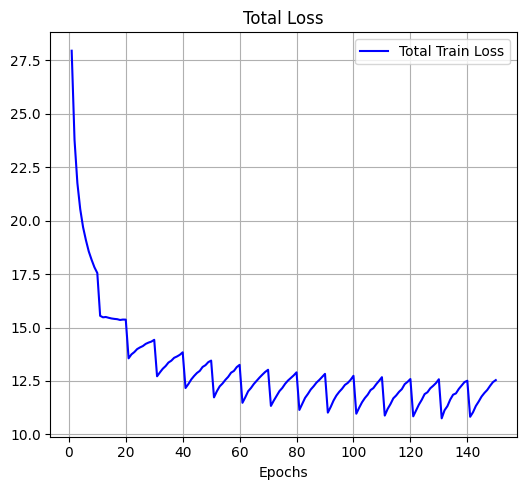

In [10]:
import matplotlib.pyplot as plt

def plot_vae_convergence(history):
    keys = history.history.keys()
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(15, 5))

    # 1. Total Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Total Train Loss')
    if 'val_loss' in keys:
        plt.plot(epochs, history.history['val_loss'], 'r--', label='Total Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)

    # 2. Reconstruction Loss (if available in logs)
    if 'recon_loss' in keys:
        plt.subplot(1, 3, 2)
        plt.plot(epochs, history.history['recon_loss'], 'g-', label='Reconstruction')
        plt.title('Reconstruction Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.grid(True)

    # 3. KL Divergence (if available in logs)
    if 'kl_loss' in keys:
        plt.subplot(1, 3, 3)
        plt.plot(epochs, history.history['kl_loss'], 'orange', label='KL Divergence')
        plt.title('KL Divergence')
        plt.xlabel('Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the plot
plot_vae_convergence(history)


GENERATING MOLECULES WITH IMPROVEMENTS
Generating 50 molecules with property conditioning...
----------------------------------------
  ✓ Valid: O=CCCCCCCO
  ✓ Valid: CCCNCCNC
  ✓ Valid: CCCCCOCO
  ✓ Valid: CC1CCC(N)(O)N1
  ✓ Valid: CC1CCCC1CO
  ✓ Valid: CCCOCCCCO
  ✓ Valid: CC1(CO)COC(O)O1
  ✓ Valid: OCCON1CCNC1
  ✓ Valid: CCCCCCCC
  ✓ Valid: CC12COCC1C2C#N
  ✓ Valid: CC1CC1(C)CC=O
  ✓ Valid: CNCCC1CC1C=O
  ✓ Valid: CC1CNCNNCN1
  ✓ Valid: COCCCCCCO
  ✓ Valid: CC1OCCOC1N
  ✓ Valid: CC1CCCCCC1O
  ✓ Valid: CCCCCCOC
  ✓ Valid: OCCCCCCCO
  ✓ Valid: CC(CC=N)NCO
  ✓ Valid: CCCOCCCCO
  ✓ Valid: CCCCCOCCC
  ✓ Valid: CCCCC1CC1CC
  ✓ Valid: OCCNC1CCC1
  ✓ Valid: CC(C)C1(C)CCC1C
  ✓ Valid: CCCCCCCO
  ✓ Valid: CCCCCCCCC
  ✓ Valid: CC1NC1(C)CCO
  ✓ Valid: CCCCCCCC
  ✓ Valid: CCC1NC12CCN2
  ✓ Valid: CC=CCC1CCO1
  ✓ Valid: O=CC1CC1CCCO
  ✓ Valid: CC(=O)C1C2=CC2C1C
  ✓ Valid: CCC1CC(CC)C1=O
  ✓ Valid: CN1CC12CC2C1CO1
  ✓ Valid: C=C1C2CCC1C(C)C2
  ✓ Valid: CCNCCCCCO
  ✓ Valid: CCCC(C)CCCO
  ✓ Valid: C

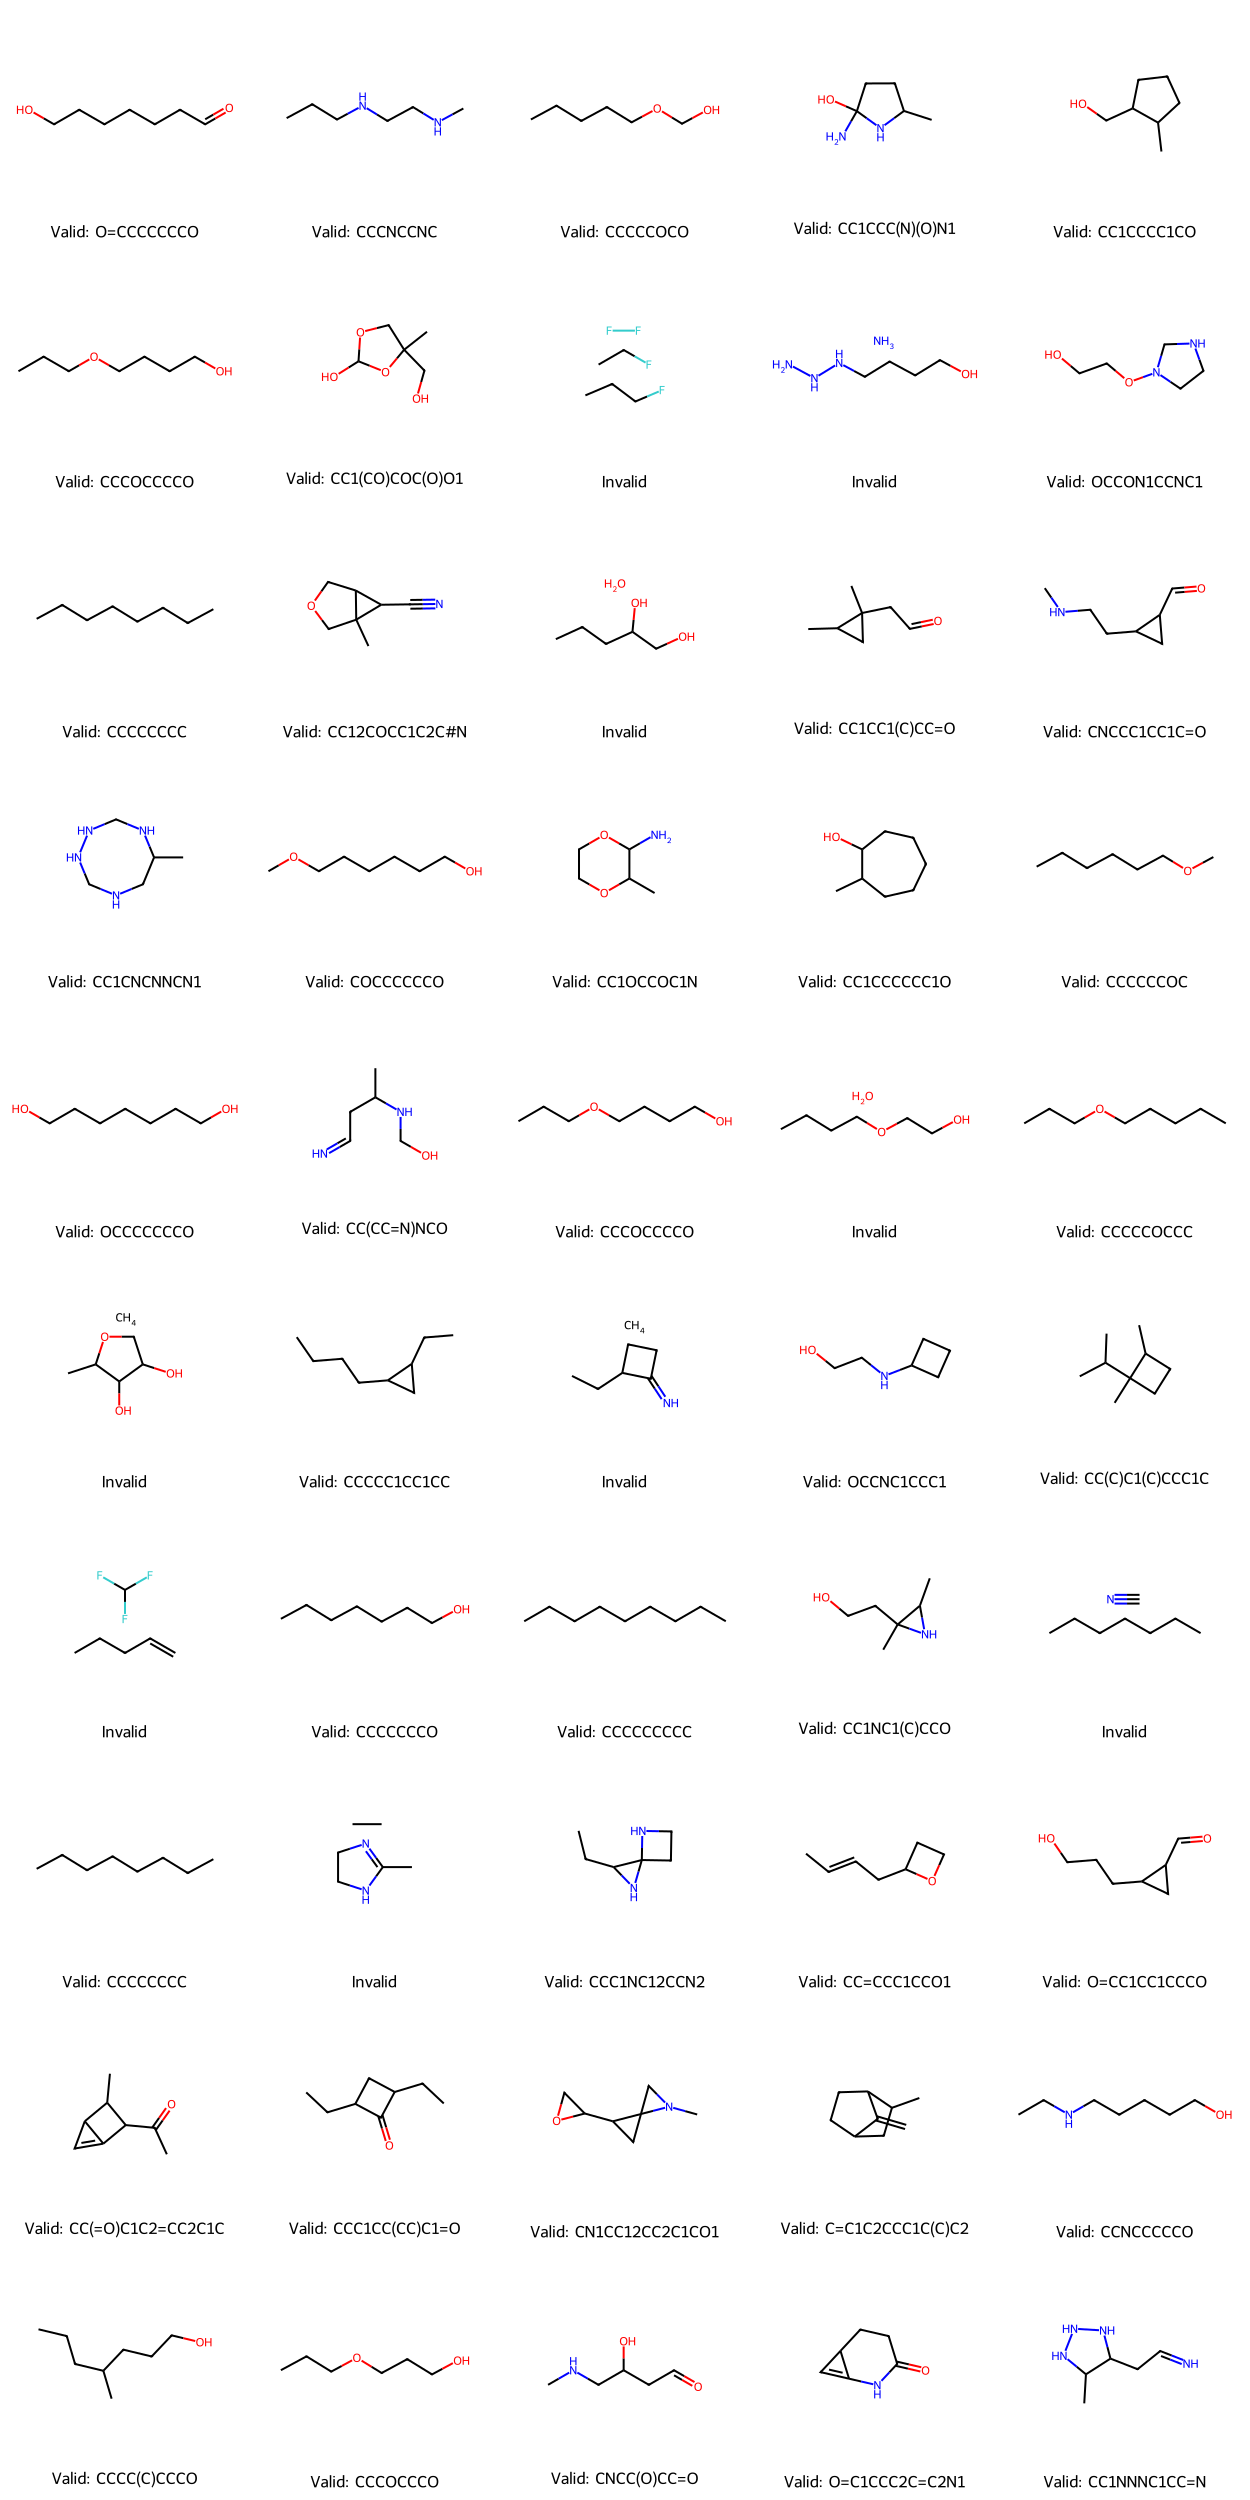

In [11]:
# ==========================================
# IMPROVED GENERATION & VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Function 1: Generate with Property Conditioning
def generate_and_store_molecules(model, properties, n_samples=20):
    """
    Generate molecules using the conditional VAE with property conditioning.
    Uses improved graph_to_molecule with valence checking.
    """
    print(f"Generating {n_samples} molecules with property conditioning...")

    # Sample latent vectors
    z = tf.random.normal((n_samples, CONFIG.LATENT_DIM))

    # Use random properties from the dataset for conditioning
    prop_indices = np.random.choice(len(properties), n_samples)
    sample_props = properties[prop_indices]

    # Decode with property conditioning
    adj_pred, feat_pred = model.decoder([z, sample_props])
    adj_pred, feat_pred = adj_pred.numpy(), feat_pred.numpy()

    stored_mols = []
    stored_legends = []
    valid_smiles = []

    print("-" * 40)
    for i in range(n_samples):
        # Use improved graph_to_molecule with valence checking
        mol = graph_to_molecule(adj_pred[i], feat_pred[i], check_valence=True)

        # Try to Validate
        label = "Invalid"
        if mol.GetNumAtoms() > 0:
            try:
                Chem.SanitizeMol(mol)
                smiles = Chem.MolToSmiles(mol)
                if "." not in smiles and smiles != "":
                    label = f"Valid: {smiles}"
                    valid_smiles.append(smiles)
                    print(f"  ✓ Valid: {smiles}")
            except Exception as e:
                label = "Invalid (Chemistry)"

            # Compute coords for drawing
            try:
                Chem.Compute2DCoords(mol)
            except:
                pass

            stored_mols.append(mol)
            stored_legends.append(label)

    print("-" * 40)
    validity_rate = (len(valid_smiles) / n_samples) * 100
    print(f"Validity Rate: {validity_rate:.1f}% ({len(valid_smiles)}/{n_samples})")
    return stored_mols, valid_smiles, stored_legends

# Function 2: Visualize
def visualize_molecule_array(mol_list, legend_list):
    if not mol_list:
        print("No molecules to display.")
        return None

    return Draw.MolsToGridImage(
        mol_list,
        molsPerRow=5,
        subImgSize=(250, 250),
        legends=legend_list,
        useSVG=False
    )

# --- EXECUTION ---
print("\n" + "="*50)
print("GENERATING MOLECULES WITH IMPROVEMENTS")
print("="*50)

# Generate molecules using properties from the dataset
my_mols, valid_smiles, my_legends = generate_and_store_molecules(vae, all_props, n_samples=50)

# Visualize
img = visualize_molecule_array(my_mols, my_legends)
img

In [12]:
# ==========================================
# IMPROVED MODEL EVALUATION
# ==========================================
def evaluate_model_performance(model, properties, train_smiles_list, n_samples=1000):
    """
    Comprehensive evaluation using improved reconstruction with valence checking.
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING MODEL PERFORMANCE (N={n_samples})")
    print(f"{'='*60}")

    # 1. Generate samples with property conditioning
    z = tf.random.normal((n_samples, CONFIG.LATENT_DIM))

    # Use random properties for conditioning
    prop_indices = np.random.choice(len(properties), n_samples)
    sample_props = properties[prop_indices]

    adj_pred, feat_pred = model.decoder([z, sample_props])
    adj_pred, feat_pred = adj_pred.numpy(), feat_pred.numpy()

    valid_smiles = []

    # 2. Convert to SMILES using improved reconstruction
    print("Generating and validating molecules...")
    for i in range(n_samples):
        # Use improved graph_to_molecule with valence checking
        mol = graph_to_molecule(adj_pred[i], feat_pred[i], check_valence=True)

        # Check Validity
        if mol.GetNumAtoms() > 0:
            try:
                Chem.SanitizeMol(mol)
                s = Chem.MolToSmiles(mol)
                if "." not in s and s != "":
                    valid_smiles.append(s)
            except:
                pass

    # 3. Calculate Metrics
    n_valid = len(valid_smiles)
    validity = (n_valid / n_samples) * 100

    unique_smiles = set(valid_smiles)
    n_unique = len(unique_smiles)
    uniqueness = (n_unique / n_valid * 100) if n_valid > 0 else 0.0

    # Compare against Training Data for Novelty
    train_set = set(train_smiles_list)
    new_molecules = unique_smiles - train_set
    n_novel = len(new_molecules)
    novelty = (n_novel / n_unique * 100) if n_unique > 0 else 0.0

    # 4. Print Report
    print(f"\n{'='*60}")
    print(f"           MOLECULAR GENERATION METRICS")
    print(f"{'='*60}")
    print(f"✓ Validity:    {validity:.2f}%  ({n_valid}/{n_samples})")
    print(f"✓ Uniqueness:  {uniqueness:.2f}%  ({n_unique}/{n_valid if n_valid > 0 else 1})")
    print(f"✓ Novelty:     {novelty:.2f}%  ({n_novel}/{n_unique if n_unique > 0 else 1})")
    print(f"{'='*60}")

    if n_valid == 0:
        print("⚠ WARNING: Model generating 0 valid molecules!")
        print("   Recommendations: Train longer or adjust hyperparameters")
    elif validity < 50:
        print("⚠ Low validity rate detected. Consider:")
        print("   - Training for more epochs")
        print("   - Adjusting max_beta value")
        print("   - Checking data preprocessing")
    else:
        print("✓ Model performance is good!")
        print(f"\nSample valid molecules:")
        for i, smiles in enumerate(list(unique_smiles)[:10]):
            print(f"  {i+1}. {smiles}")

    return valid_smiles, validity, uniqueness, novelty

# --- EXECUTE EVALUATION ---
results = evaluate_model_performance(vae, all_props, qm9_smiles, n_samples=1000)


EVALUATING MODEL PERFORMANCE (N=1000)
Generating and validating molecules...

           MOLECULAR GENERATION METRICS
✓ Validity:    75.50%  (755/1000)
✓ Uniqueness:  72.19%  (545/755)
✓ Novelty:     69.54%  (379/545)
✓ Model performance is good!

Sample valid molecules:
  1. CCCOCCNC
  2. CCCNCCC
  3. CN(C)CCCCCN
  4. CCC1CCOCN1
  5. N#CC1C(O)CC12CO2
  6. CCCCCCC(C)=O
  7. NCCCCCCO
  8. CCC=CCCCCO
  9. CCCCC#CCCN
  10. CCCOCCCOO


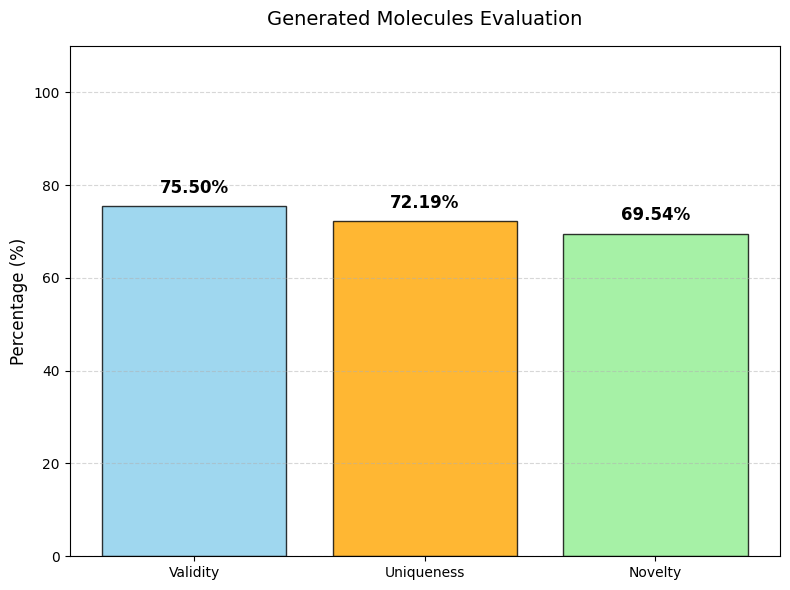

In [21]:
import matplotlib.pyplot as plt

def plot_single_evaluation(results_tuple):
    """
    Plots the Validity, Uniqueness, and Novelty from the results tuple.
    Assumes results_tuple = (valid_smiles, validity, uniqueness, novelty)
    """
    # 1. Unpack the results
    # Index 0 is the list of SMILES, which we don't need for the plot
    _, validity, uniqueness, novelty = results_tuple

    # 2. Prepare Data for Plotting
    metrics = ['Validity', 'Uniqueness', 'Novelty']
    values = [validity, uniqueness, novelty]
    colors = ['skyblue', 'orange', 'lightgreen']

    # 3. Create Bar Chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)

    # 4. Styling
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title('Generated Molecules Evaluation', fontsize=14, pad=15)
    plt.ylim(0, 110)  # Set limit slightly above 100 for text space
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # 5. Add Value Labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 2,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

# --- Plot the Results ---
if 'results' in locals():
    plot_single_evaluation(results)
else:
    print("Variable 'results' not found. Please run the 'evaluate_model_performance' function first.")